In [1]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from al_util import *
from graph_util import *
from sklearn.cluster import SpectralClustering
import scipy.sparse as sparse

In [2]:
def mult_al_tests(W, X, labels, evecs, evals, dataset=None, gamma=0.5, num_tests=10, al_choices=150):
    deg = gl.degree_matrix(W).diagonal()
    for j in range(num_tests):
        print(f"Test {j+1}/{num_tests}")
        if dataset == 'checkerboard':
            train_ind = get_adjacent_square_inds(X)
        else:
            train_ind = gl.randomize_labels(labels, 1)
        
        
        # Beta-VOpt
        acc, beta_vopt_labeled_ind, acc_ll = al_test(W, X, train_ind, labels, evecs, evals, al_iters=al_choices, method='vopt', \
                 return_ll=True)
        
        if j == 0:
            beta_vopt_acc, beta_vopt_acc_ll = acc[np.newaxis, :], acc_ll[np.newaxis,:]
        else:
            beta_vopt_acc = np.vstack((beta_vopt_acc, acc[np.newaxis,:]))
            beta_vopt_acc_ll = np.vstack((beta_vopt_acc_ll, acc_ll[np.newaxis,:]))
    
        # Beta-Ryan
        acc, beta_ryan_labeled_ind, acc_ll = al_test(W, X, train_ind, labels, evecs, evals, al_iters=al_choices, method='ryan', \
                    return_ll=True)
        
        if j == 0:
            beta_ryan_acc, beta_ryan_acc_ll = acc[np.newaxis, :], acc_ll[np.newaxis,:]
        else:
            beta_ryan_acc = np.vstack((beta_ryan_acc, acc[np.newaxis,:]))
            beta_ryan_acc_ll = np.vstack((beta_ryan_acc_ll, acc_ll[np.newaxis,:]))
        
        # Beta-Var
        acc, beta_var_labeled_ind, acc_ll = al_test(W, X, train_ind, labels, evecs, evals, al_iters=al_choices, method='var',  \
                    return_ll=True)
        if j == 0:
            beta_var_acc, beta_var_acc_ll = acc[np.newaxis, :], acc_ll[np.newaxis,:]
        else:
            beta_var_acc = np.vstack((beta_var_acc, acc[np.newaxis,:]))
            beta_var_acc_ll = np.vstack((beta_var_acc_ll, acc_ll[np.newaxis,:]))
        
        # VOpt (GR)
        acc, vopt_labeled_ind = al_test_gl(W, X, train_ind, labels, evecs, evals, al_iters=al_choices, method='vopt', \
                     gamma=gamma)
        if j == 0:
            vopt_acc = acc[np.newaxis, :]
        else:
            vopt_acc = np.vstack((vopt_acc, acc[np.newaxis,:]))
            
        # Laplace Learning Uncertainty
        acc, uncertainty_labeled_ind = al_test_gl(W, X, train_ind, labels, evecs, evals, al_iters=al_choices, method='uncertainty', \
                    gamma=gamma)
        if j == 0:
            uncertainty_acc = acc[np.newaxis, :]
        else:
            uncertainty_acc = np.vstack((uncertainty_acc, acc[np.newaxis,:]))
            
        # Poisson Learning Uncertainty
        acc, poisson_uncertainty_labeled_ind = al_test_gl(W, X, train_ind, labels, evecs, evals, al_iters=al_choices, method='uncertainty', \
                    algorithm='poisson',gamma=gamma)
        if j == 0:
            poisson_uncertainty_acc = acc[np.newaxis, :]
        else:
            poisson_uncertainty_acc = np.vstack((poisson_uncertainty_acc, acc[np.newaxis,:]))
        
        # Beta-Deg-Var
        acc, beta_degvar_labeled_ind, acc_ll = al_test(W, X, train_ind, labels, evecs, evals, al_iters=al_choices, method='deg-var', \
                 deg=deg, return_ll=True)
        
        if j == 0:
            beta_degvar_acc, beta_degvar_acc_ll = acc[np.newaxis, :], acc_ll[np.newaxis,:]
        else:
            beta_degvar_acc = np.vstack((beta_degvar_acc, acc[np.newaxis,:]))
            beta_degvar_acc_ll = np.vstack((beta_degvar_acc_ll, acc_ll[np.newaxis,:]))
            
            
    return beta_vopt_acc, beta_vopt_acc_ll, beta_ryan_acc, beta_ryan_acc_ll, beta_var_acc, beta_var_acc_ll, \
            vopt_acc, uncertainty_acc, poisson_uncertainty_acc, beta_degvar_acc, beta_degvar_acc_ll

# Binary Clusters Test

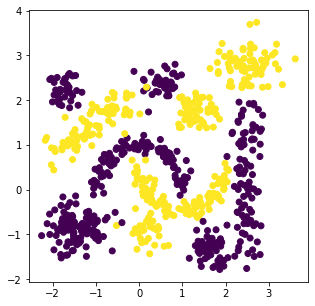

In [3]:
X, labels = create_binary_clusters()
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X[:,0], X[:,1], c=labels)
plt.show()

In [4]:
W = knn_weight_matrix(15, X)
L = gl.graph_laplacian(W, norm='none')
deg = gl.degree_matrix(W).diagonal()
evals, evecs = eigsh(L, k=500, which='SM')

train_ind = gl.randomize_labels(labels, 1)
c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]

kNN search with Annoy approximate nearest neighbor package...


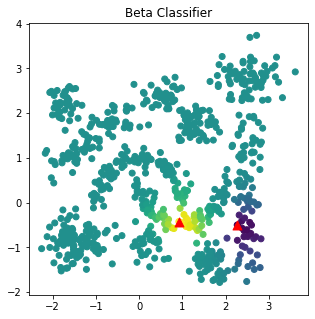

In [5]:
alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .5, thresh=1e-9)
p = (alpha+1.)/(alpha + beta+2.)
p[np.isnan(p)] = 0.5

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X[:,0], X[:,1], c=p)
ax.scatter(X[train_ind, 0], X[train_ind, 1], c='r', marker='^', s=80)
ax.set_title("Beta Classifier")
plt.show()

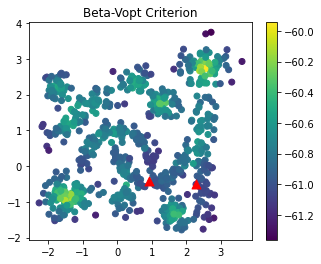

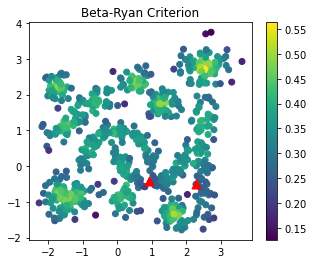

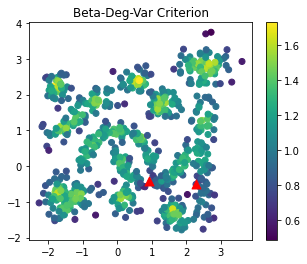

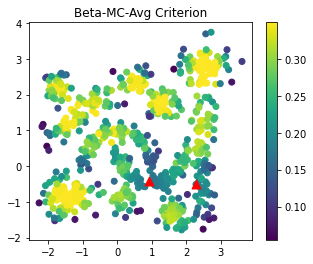

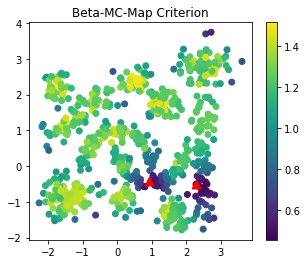

In [6]:
unlabeled_ind = np.delete(np.arange(W.shape[0]), train_ind)

beta_vopt_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='vopt', dt=.5)

beta_ryan_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='ryan', dt=.5, show=True, thresh=1e-9)

beta_deg_var_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='deg-var', dt=.5, show=True, thresh=1e-9, deg=deg)

beta_mc_avg_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='mc-avg', dt=.5, show=True, thresh=1e-9, c0_ind=c0_ind, c1_ind=c1_ind)
beta_mc_map_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='mc-map', dt=.5, show=True, thresh=1e-9, c0_ind=c0_ind, c1_ind=c1_ind)


fig, ax = plt.subplots(figsize=(5,4))
pl = ax.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=beta_vopt_vals)
ax.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=80)
ax.set_title("Beta-Vopt Criterion")
plt.colorbar(pl, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(5,4))
pl = ax.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=beta_ryan_vals)
ax.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=80)
ax.set_title("Beta-Ryan Criterion")
plt.colorbar(pl, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(5,4))
pl = ax.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=beta_deg_var_vals)
ax.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=80)
ax.set_title("Beta-Deg-Var Criterion")
plt.colorbar(pl, ax=ax)
plt.show()



fig, ax = plt.subplots(figsize=(5,4))
pl = ax.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=beta_mc_avg_vals)
ax.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=80)
ax.set_title("Beta-MC-Avg Criterion")
plt.colorbar(pl, ax=ax)
plt.show()


fig, ax = plt.subplots(figsize=(5,4))
pl = ax.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=beta_mc_map_vals)
ax.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=80)
ax.set_title("Beta-MC-Map Criterion")
plt.colorbar(pl, ax=ax)
plt.show()

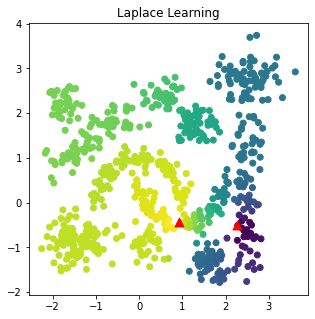

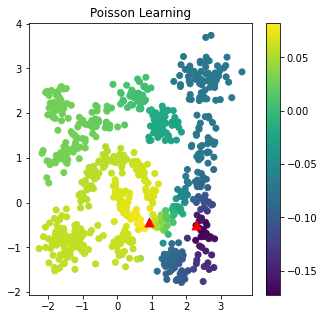

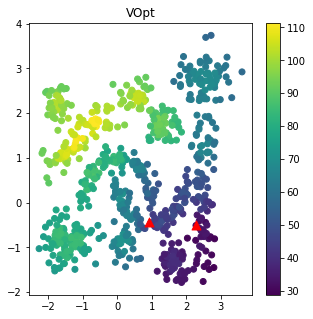

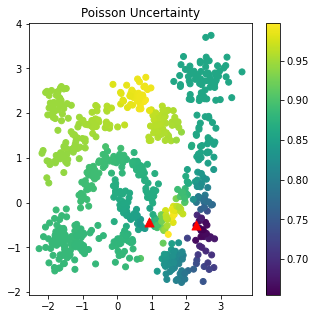

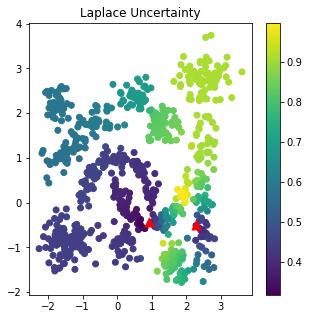

In [7]:
u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)
gamma = 0.5

C_a = np.linalg.inv(np.diag(evals) + evecs[train_ind,:].T @ evecs[train_ind,:] / gamma**2.) # M by M covariance matrix

vopt_vals = acquisition_function(C_a, evecs, unlabeled_ind, u_laplace, method='vopt', gamma=gamma)
laplace_uncertainty_vals = acquisition_function(C_a, evecs, unlabeled_ind, u_laplace, method='uncertainty', \
                                                uncertainty_method='smallest_margin', gamma=gamma)
poisson_uncertainty_vals = acquisition_function(C_a, evecs, unlabeled_ind, u_poisson, method='uncertainty', \
                                                uncertainty_method='smallest_margin', gamma=gamma)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=u_laplace[unlabeled_ind,1])
ax.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=80)
ax.set_title("Laplace Learning")
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
pl = ax.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=u_poisson[unlabeled_ind,1])
ax.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=80)
ax.set_title("Poisson Learning")
plt.colorbar(pl, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
pl = ax.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=vopt_vals)
ax.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=80)
ax.set_title("VOpt")
plt.colorbar(pl, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
pl = ax.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=poisson_uncertainty_vals)
ax.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=80)
ax.set_title("Poisson Uncertainty")
plt.colorbar(pl, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
pl = ax.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=laplace_uncertainty_vals)
ax.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=80)
ax.set_title("Laplace Uncertainty")
plt.colorbar(pl, ax=ax)
plt.show()


In [8]:
beta_vopt_acc_, beta_vopt_labeled_ind, beta_vopt_acc_ll_ = al_test(W, X, train_ind, labels, evecs, evals, al_iters=100, method='vopt', classifier='mean', \
            kernel='heat', dt=.5, thresh=1e-9, show=False, return_ll=True)

print('done')
beta_ryan_acc_, beta_ryan_labeled_ind, beta_ryan_acc_ll_ = al_test(W, X, train_ind, labels, evecs, evals, al_iters=100, method='ryan', classifier='mean', \
            kernel='heat', dt=.5, thresh=1e-9, show=False, return_ll=True)
print('done')
beta_mc_avg_acc_, beta_mc_avg_labeled_ind, beta_mc_avg_acc_ll_ = al_test(W, X, train_ind, labels, evecs, evals, al_iters=100, method='mc-avg', classifier='mean', \
            kernel='heat', dt=.5, thresh=1e-9, show=False, return_ll=True)
print('done')
beta_mc_map_acc_, beta_mc_map_labeled_ind, beta_mc_map_acc_ll_ = al_test(W, X, train_ind, labels, evecs, evals, al_iters=100, method='mc-map', classifier='mean', \
            kernel='heat', dt=.5, thresh=1e-9, show=False, return_ll=True)
print('done')
beta_var_acc_, beta_var_labeled_ind, beta_var_acc_ll_ = al_test(W, X, train_ind, labels, evecs, evals, al_iters=100, method='var', classifier='mean', \
            kernel='heat', dt=.5, thresh=1e-9, show=False, return_ll=True)
print('done')
beta_deg_var_acc_, beta_deg_var_labeled_ind, beta_deg_var_acc_ll_ = al_test(W, X, train_ind, labels, evecs, evals, al_iters=100, method='deg-var', classifier='mean', \
            kernel='heat', dt=.5, thresh=1e-9, show=False, return_ll=True, deg=deg)
print('done')
vopt_acc_, vopt_labeled_ind = al_test_gl(W, X, train_ind, labels, evecs, evals, al_iters=100, method='vopt', \
            show=False, gamma=0.5)
print('done')
uncertainty_acc_, uncertainty_labeled_ind = al_test_gl(W, X, train_ind, labels, evecs, evals, al_iters=100, method='uncertainty', \
            show=False, gamma=0.5)
print('last')
poisson_uncertainty_acc_, poisson_uncertainty_labeled_ind = al_test_gl(W, X, train_ind, labels, evecs, evals, al_iters=100, method='uncertainty', \
            algorithm='poisson', show=False, gamma=0.5)

done
done
done
done
done
done
done
last


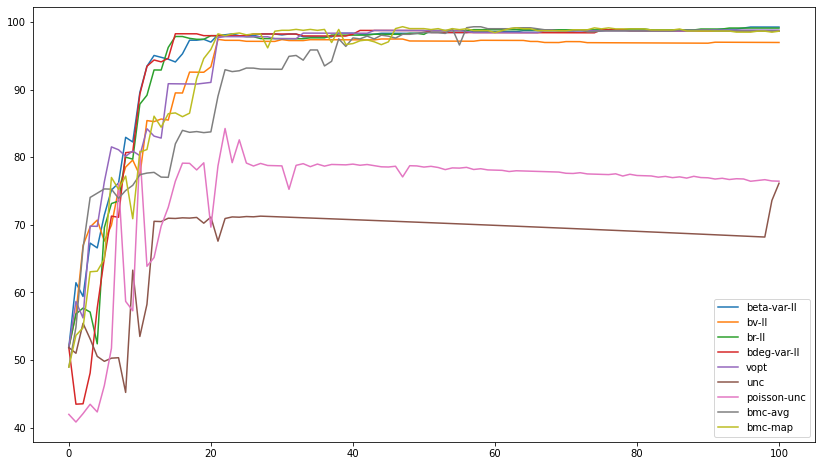

In [10]:
plt.figure(figsize= (14,8))
# plt.plot(np.arange(len(beta_vopt_acc_)), beta_var_acc_, label='beta-var')
plt.plot(np.arange(len(beta_vopt_acc_)), beta_var_acc_ll_, label='beta-var-ll')
# plt.plot(np.arange(len(beta_vopt_acc_)), beta_vopt_acc_, label='bv-b')
plt.plot(np.arange(len(beta_vopt_acc_)), beta_vopt_acc_ll_, label='bv-ll')
# plt.plot(np.arange(len(beta_vopt_acc_)), beta_ryan_acc_, label='br-b')
plt.plot(np.arange(len(beta_vopt_acc_)), beta_ryan_acc_ll_, label='br-ll')
# plt.plot(np.arange(len(beta_vopt_acc_)), beta_deg_var_acc_, label='bdeg-var-b')
plt.plot(np.arange(len(beta_vopt_acc_)), beta_deg_var_acc_ll_, label='bdeg-var-ll')
plt.plot(np.arange(len(beta_vopt_acc_)), vopt_acc_, label='vopt')
plt.plot(np.arange(len(beta_vopt_acc_)), uncertainty_acc_, label='unc')
plt.plot(np.arange(len(beta_vopt_acc_)), poisson_uncertainty_acc_, label='poisson-unc')
# plt.plot(np.arange(len(beta_vopt_acc_)), beta_mc_avg_acc_ll_, label='bmc-avg-ll')
# plt.plot(np.arange(len(beta_vopt_acc_)), beta_mc_map_acc_ll_, label='bmc-map-ll')
plt.plot(np.arange(len(beta_vopt_acc_)), beta_mc_avg_acc_, label='bmc-avg')
plt.plot(np.arange(len(beta_vopt_acc_)), beta_mc_map_acc_, label='bmc-map')
plt.legend()
plt.show()

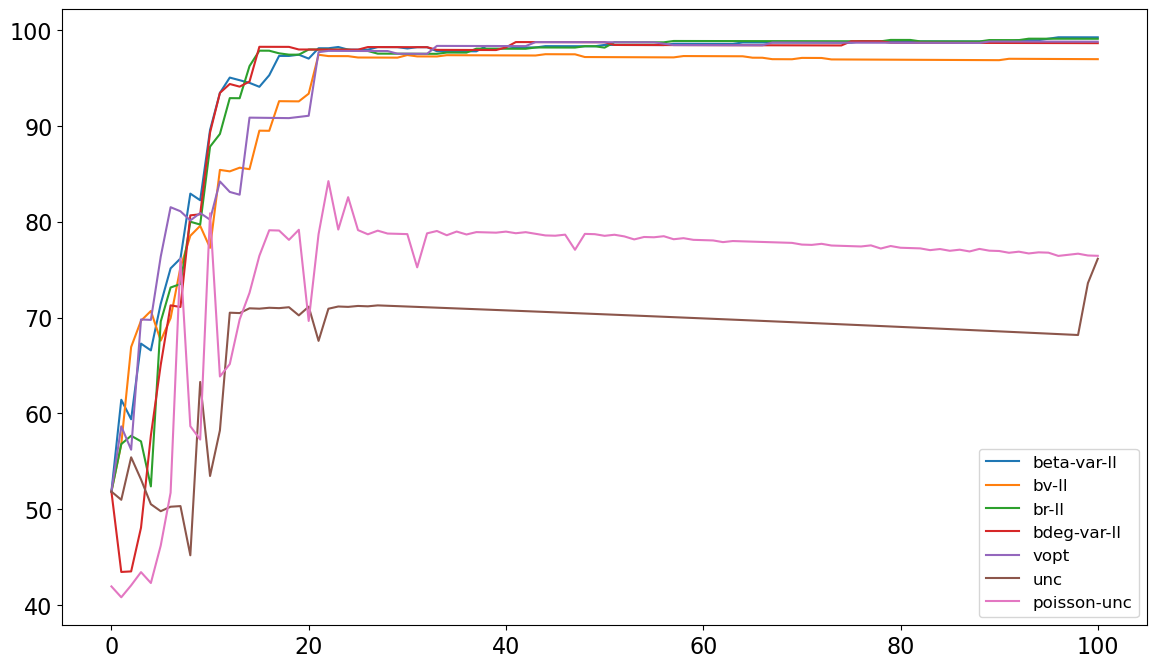

In [54]:
plt.figure(figsize= (14,8))
# plt.plot(np.arange(len(beta_vopt_acc_)), beta_var_acc_, label='beta-var')
plt.plot(np.arange(len(beta_vopt_acc_)), beta_var_acc_ll_, label='beta-var-ll')
# plt.plot(np.arange(len(beta_vopt_acc_)), beta_vopt_acc_, label='bv-b')
plt.plot(np.arange(len(beta_vopt_acc_)), beta_vopt_acc_ll_, label='bv-ll')
# plt.plot(np.arange(len(beta_vopt_acc_)), beta_ryan_acc_, label='br-b')
plt.plot(np.arange(len(beta_vopt_acc_)), beta_ryan_acc_ll_, label='br-ll')
# plt.plot(np.arange(len(beta_vopt_acc_)), beta_deg_var_acc_, label='bdeg-var-b')
plt.plot(np.arange(len(beta_vopt_acc_)), beta_deg_var_acc_ll_, label='bdeg-var-ll')
plt.plot(np.arange(len(beta_vopt_acc_)), vopt_acc_, label='vopt')
plt.plot(np.arange(len(beta_vopt_acc_)), uncertainty_acc_, label='unc')
plt.plot(np.arange(len(beta_vopt_acc_)), poisson_uncertainty_acc_, label='poisson-unc')
plt.legend()
plt.show()

In [12]:
import matplotlib
matplotlib.rcdefaults()

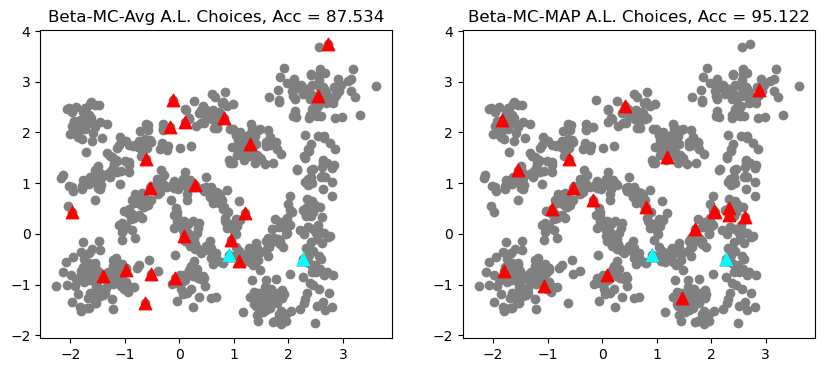

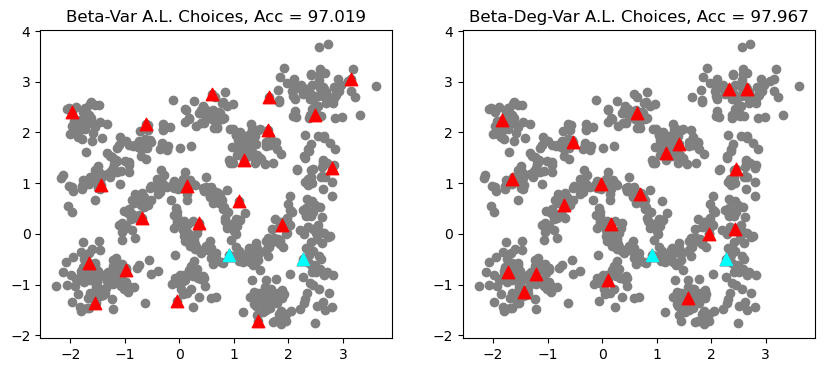

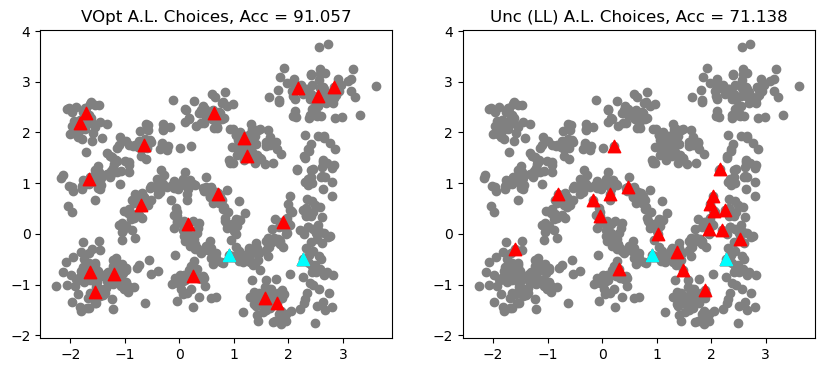

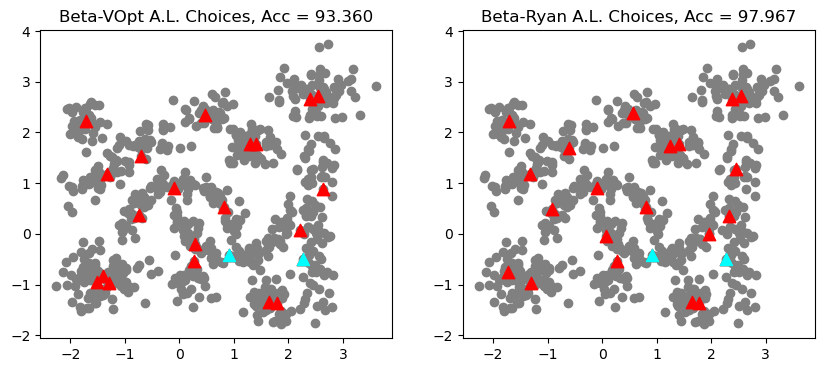

In [13]:
k = 20
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c='gray')
ax1.scatter(X[beta_mc_avg_labeled_ind[:k+2],0], X[beta_mc_avg_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax1.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax1.set_title(f"Beta-MC-Avg A.L. Choices, Acc = {beta_mc_avg_acc_ll_[k]:.3f}")
ax2.scatter(X[:,0], X[:,1], c='gray')
ax2.scatter(X[beta_mc_map_labeled_ind[:k+2],0], X[beta_mc_map_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax2.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax2.set_title(f"Beta-MC-MAP A.L. Choices, Acc = {beta_mc_map_acc_ll_[k]:.3f}")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c='gray')
ax1.scatter(X[beta_var_labeled_ind[:k+2],0], X[beta_var_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax1.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax1.set_title(f"Beta-Var A.L. Choices, Acc = {beta_var_acc_ll_[k]:.3f}")
ax2.scatter(X[:,0], X[:,1], c='gray')
ax2.scatter(X[beta_deg_var_labeled_ind[:k+2],0], X[beta_deg_var_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax2.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax2.set_title(f"Beta-Deg-Var A.L. Choices, Acc = {beta_deg_var_acc_ll_[k]:.3f}")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c='gray')
ax1.scatter(X[vopt_labeled_ind[:k+2],0], X[vopt_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax1.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax1.set_title(f"VOpt A.L. Choices, Acc = {vopt_acc_[k]:.3f}")
ax2.scatter(X[:,0], X[:,1], c='gray')
ax2.scatter(X[uncertainty_labeled_ind[:k+2],0], X[uncertainty_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax2.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax2.set_title(f"Unc (LL) A.L. Choices, Acc = {uncertainty_acc_[k]:.3f}")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c='gray')
ax1.scatter(X[beta_vopt_labeled_ind[:k+2],0], X[beta_vopt_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax1.set_title(f"Beta-VOpt A.L. Choices, Acc = {beta_vopt_acc_ll_[k]:.3f}")
ax1.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax2.scatter(X[:,0], X[:,1], c='gray')
ax2.scatter(X[beta_ryan_labeled_ind[:k+2],0], X[beta_ryan_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax2.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax2.set_title(f"Beta-Ryan A.L. Choices, Acc = {beta_ryan_acc_ll_[k]:.3f}")
plt.show()

In [14]:
print(train_ind)

[697 148]


In [67]:
matplotlib.rcdefaults()

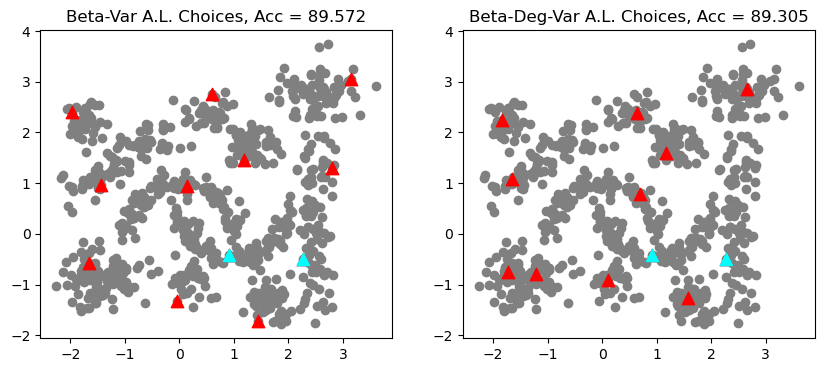

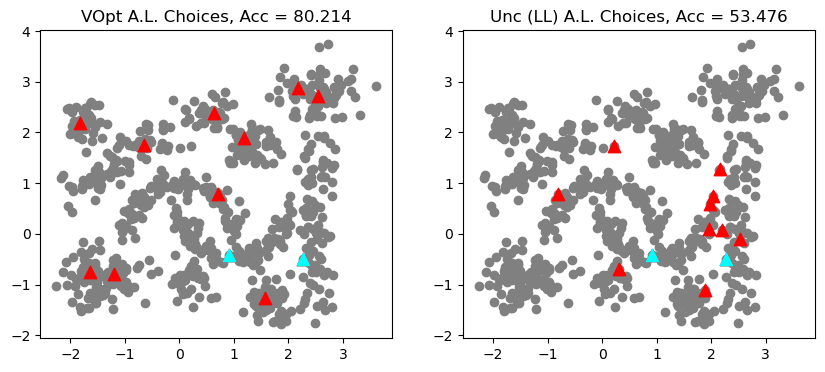

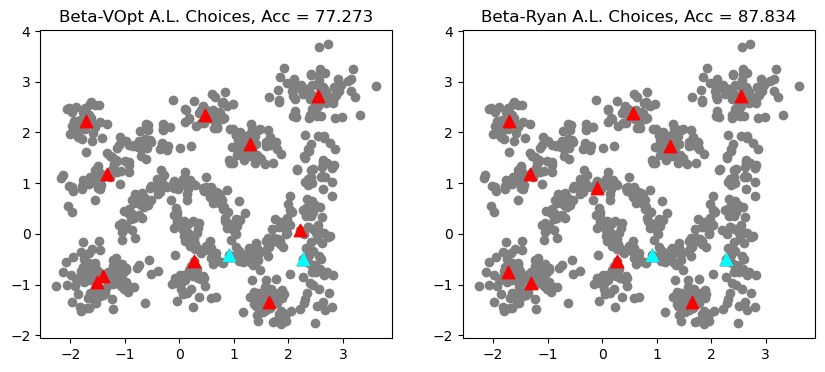

In [68]:
k = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c='gray')
ax1.scatter(X[beta_var_labeled_ind[:k+2],0], X[beta_var_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax1.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax1.set_title(f"Beta-Var A.L. Choices, Acc = {beta_var_acc_ll_[k]:.3f}")
ax2.scatter(X[:,0], X[:,1], c='gray')
ax2.scatter(X[beta_deg_var_labeled_ind[:k+2],0], X[beta_deg_var_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax2.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax2.set_title(f"Beta-Deg-Var A.L. Choices, Acc = {beta_deg_var_acc_ll_[k]:.3f}")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c='gray')
ax1.scatter(X[vopt_labeled_ind[:k+2],0], X[vopt_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax1.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax1.set_title(f"VOpt A.L. Choices, Acc = {vopt_acc_[k]:.3f}")
ax2.scatter(X[:,0], X[:,1], c='gray')
ax2.scatter(X[uncertainty_labeled_ind[:k+2],0], X[uncertainty_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax2.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax2.set_title(f"Unc (LL) A.L. Choices, Acc = {uncertainty_acc_[k]:.3f}")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c='gray')
ax1.scatter(X[beta_vopt_labeled_ind[:k+2],0], X[beta_vopt_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax1.set_title(f"Beta-VOpt A.L. Choices, Acc = {beta_vopt_acc_ll_[k]:.3f}")
ax1.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax2.scatter(X[:,0], X[:,1], c='gray')
ax2.scatter(X[beta_ryan_labeled_ind[:k+2],0], X[beta_ryan_labeled_ind[:k+2],1], c='r', marker='^', s=80)
ax2.scatter(X[train_ind,0], X[train_ind,1], c='cyan', marker='^', s=80)
ax2.set_title(f"Beta-Ryan A.L. Choices, Acc = {beta_ryan_acc_ll_[k]:.3f}")
plt.show()

In [12]:
# Many Tests
beta_vopt_acc, beta_vopt_acc_ll, beta_ryan_acc, beta_ryan_acc_ll, beta_var_acc, beta_var_acc_ll, vopt_acc, uncertainty_acc, poisson_uncertainty_acc, beta_deg_var_acc, beta_deg_var_acc_ll = mult_al_tests(W, X, labels, evecs, evals)


Test 1/10
Test 2/10
Test 3/10
Test 4/10
Test 5/10
Test 6/10
Test 7/10
Test 8/10
Test 9/10
Test 10/10


In [13]:
beta_var_acc.shape, beta_vopt_acc.shape

((10, 151), (10, 151))

In [ ]:
np.savez('clusters_results.npz', beta_vopt_acc=beta_vopt_acc, beta_vopt_acc_ll=beta_vopt_acc_ll, \
         beta_ryan_acc=beta_ryan_acc, beta_ryan_acc_ll=beta_ryan_acc_ll, beta_var_acc=beta_var_acc, \
         beta_var_acc_ll=beta_var_acc_ll, vopt_acc=vopt_acc, uncertainty_acc=uncertainty_acc, \
         poisson_uncertainty_acc=poisson_uncertainty_acc, beta_deg_var_acc=beta_deg_var_acc, \
         beta_deg_var_acc_ll=beta_deg_var_acc_ll, X=X, W=W)

In [61]:
import matplotlib 
styles = ['^b-','or-','dg-','pm-','xc-','sk-', '*y-']
legend_fontsize = 12
label_fontsize = 16
fontsize = 16
matplotlib.rcParams.update({'font.size': fontsize, 'legend.fontsize' : legend_fontsize, 'lines.markersize':4.0})

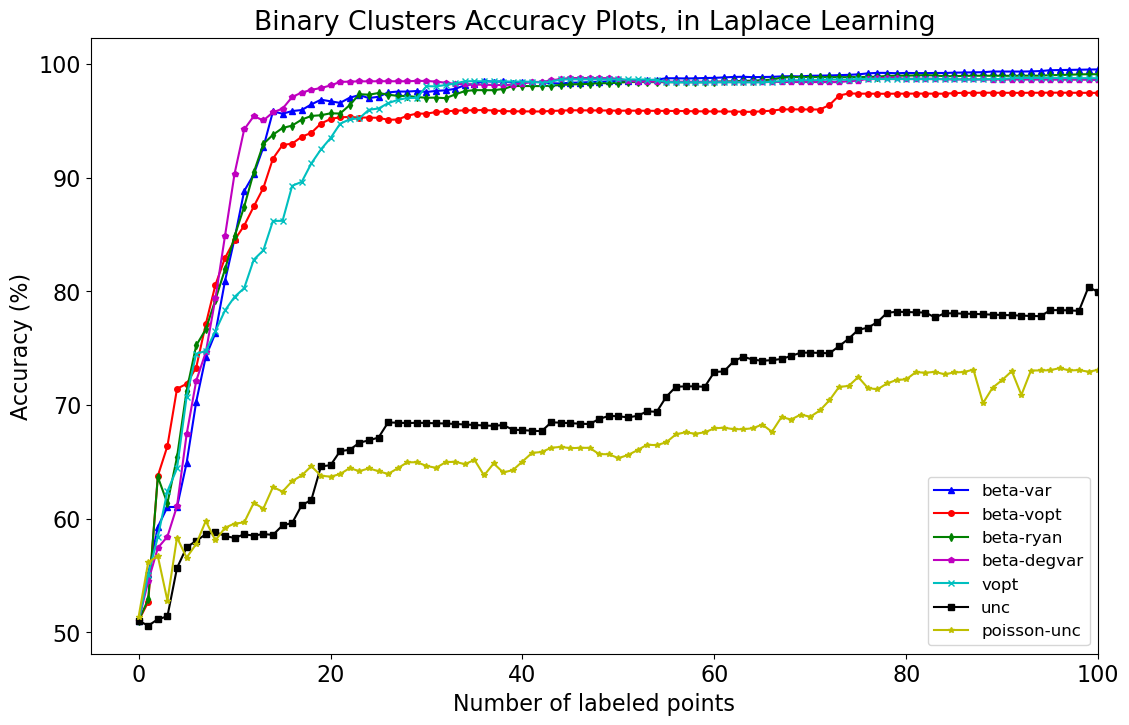

In [62]:
plot_ll = True

plt.figure(figsize= (13,8))
if not plot_ll:
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_var_acc, axis=0), styles[0], label='beta-var')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_vopt_acc, axis=0), styles[1], label='beta-vopt')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_ryan_acc, axis=0), styles[2], label='beta-ryan')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_deg_var_acc, axis=0), styles[3], label='beta-degvar')
else:
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_var_acc_ll, axis=0), styles[0], label='beta-var')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_vopt_acc_ll, axis=0), styles[1], label='beta-vopt')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_ryan_acc_ll, axis=0), styles[2], label='beta-ryan')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_deg_var_acc_ll, axis=0), styles[3], label='beta-degvar')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(vopt_acc, axis=0), styles[4], label='vopt')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(uncertainty_acc, axis=0), styles[5], label='unc')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(poisson_uncertainty_acc, axis=0), styles[6], label='poisson-unc')
# plt.plot([0, 150], [90,90], c='k', linewidth=1.5)
if plot_ll:
    plt.title("Binary Clusters Accuracy Plots, in Laplace Learning")
else:
    plt.title("Binary Clusters Accuracy Plots")
plt.xlim(-5, 100)
plt.xlabel("Number of labeled points")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

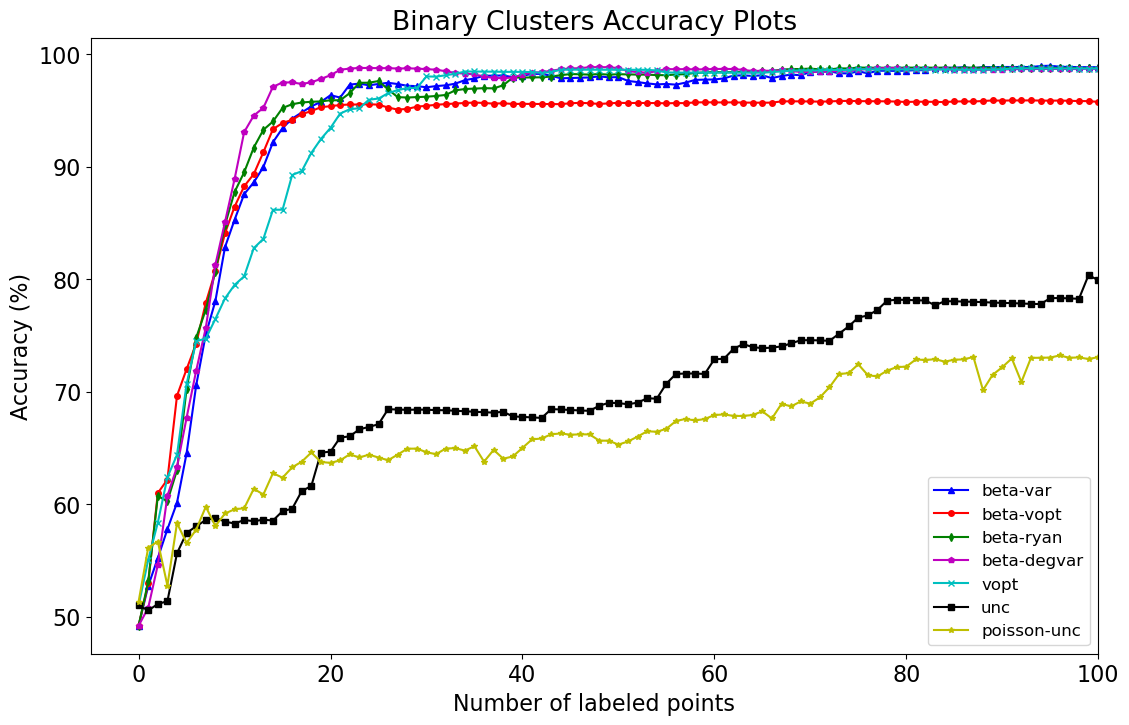

In [63]:
plot_ll = False

plt.figure(figsize= (13,8))
if not plot_ll:
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_var_acc, axis=0), styles[0], label='beta-var')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_vopt_acc, axis=0), styles[1], label='beta-vopt')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_ryan_acc, axis=0), styles[2], label='beta-ryan')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_deg_var_acc, axis=0), styles[3], label='beta-degvar')
else:
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_var_acc_ll, axis=0), styles[0], label='beta-var')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_vopt_acc_ll, axis=0), styles[1], label='beta-vopt')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_ryan_acc_ll, axis=0), styles[2], label='beta-ryan')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_deg_var_acc_ll, axis=0), styles[3], label='beta-degvar')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(vopt_acc, axis=0), styles[4], label='vopt')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(uncertainty_acc, axis=0), styles[5], label='unc')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(poisson_uncertainty_acc, axis=0), styles[6], label='poisson-unc')
# plt.plot([0, 150], [90,90], c='k', linewidth=1.5)
if plot_ll:
    plt.title("Binary Clusters Accuracy Plots, in Laplace Learning")
else:
    plt.title("Binary Clusters Accuracy Plots")
plt.xlim(-5, 100)
plt.xlabel("Number of labeled points")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

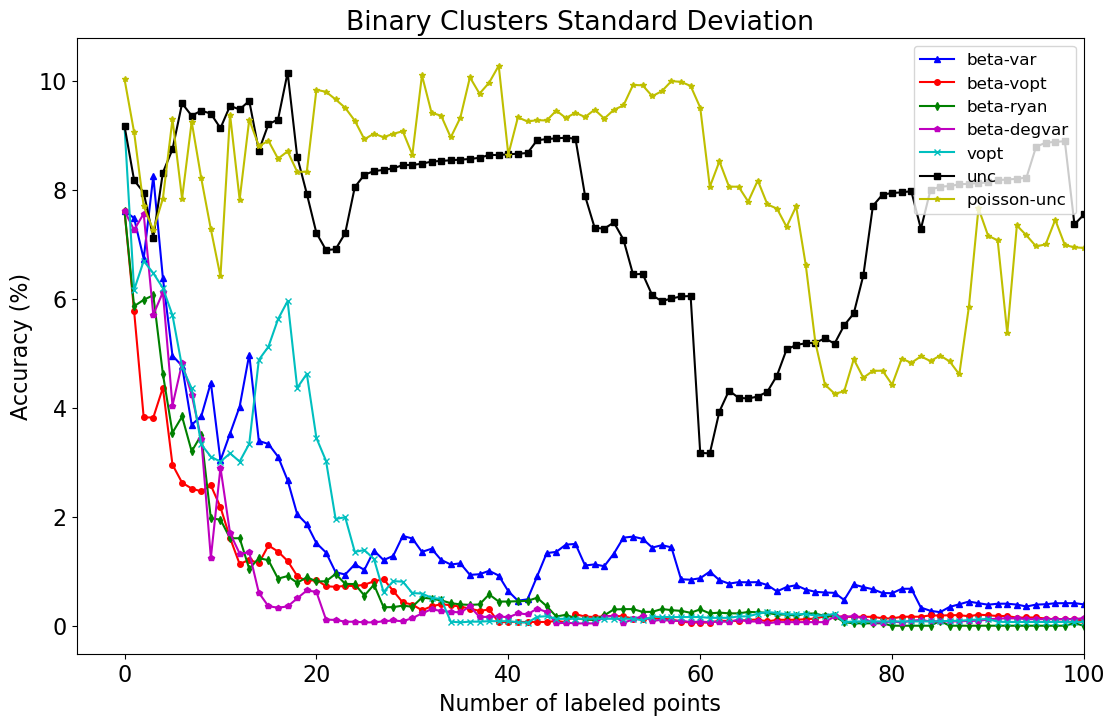

In [64]:
plot_ll = False

plt.figure(figsize= (13,8))
if not plot_ll:
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_var_acc, axis=0), styles[0], label='beta-var')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_vopt_acc, axis=0), styles[1], label='beta-vopt')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_ryan_acc, axis=0), styles[2], label='beta-ryan')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_deg_var_acc, axis=0), styles[3], label='beta-degvar')
else:
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_var_acc_ll, axis=0), styles[0], label='b-var-ll')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_vopt_acc_ll, axis=0), styles[1], label='b-vopt-ll')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_ryan_acc_ll, axis=0), styles[2], label='b-ryan-ll')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_deg_var_acc_ll, axis=0), styles[3], label='b-degvar-ll')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(vopt_acc, axis=0), styles[4], label='vopt')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(uncertainty_acc, axis=0), styles[5], label='unc')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(poisson_uncertainty_acc, axis=0), styles[6], label='poisson-unc')
# plt.plot([0, 150], [90,90], c='k', linewidth=1.5)
plt.title("Binary Clusters Standard Deviation")
plt.xlim(-5, 100)
plt.xlabel("Number of labeled points")
plt.ylabel("Accuracy (%)")
plt.legend(loc='upper right')
plt.show()

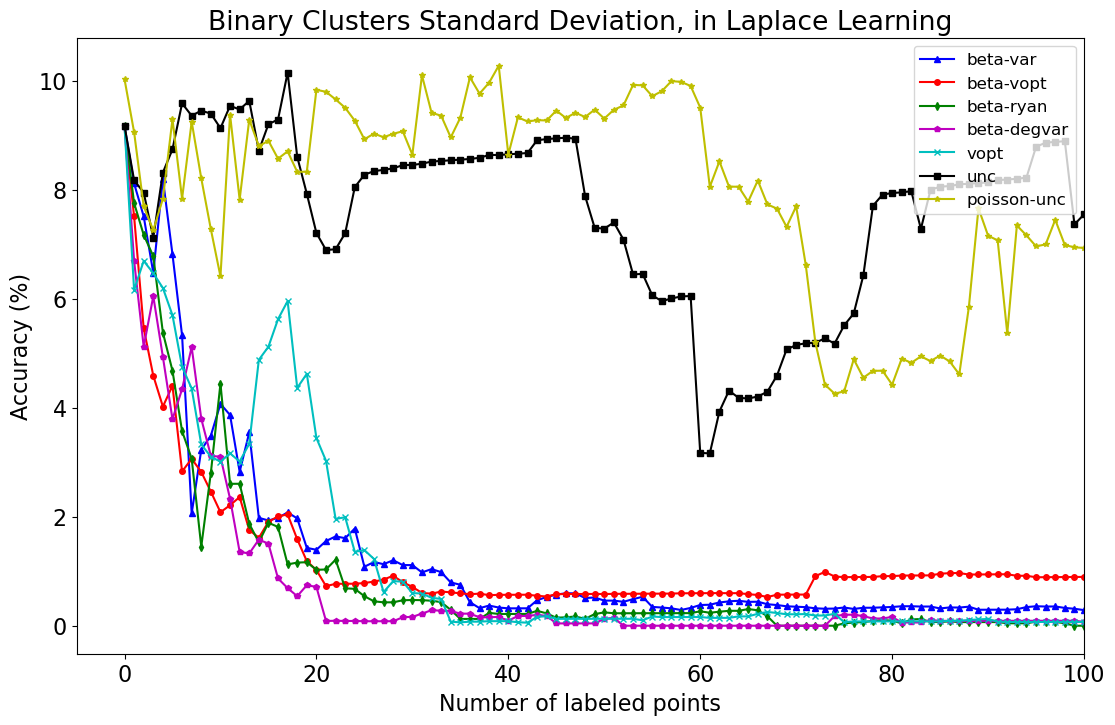

In [65]:
plot_ll = True

plt.figure(figsize= (13,8))
if not plot_ll:
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_var_acc, axis=0), styles[0], label='beta-var')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_vopt_acc, axis=0), styles[1], label='beta-vopt')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_ryan_acc, axis=0), styles[2], label='beta-ryan')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_deg_var_acc, axis=0), styles[3], label='beta-degvar')
else:
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_var_acc_ll, axis=0), styles[0], label='beta-var')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_vopt_acc_ll, axis=0), styles[1], label='beta-vopt')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_ryan_acc_ll, axis=0), styles[2], label='beta-ryan')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(beta_deg_var_acc_ll, axis=0), styles[3], label='beta-degvar')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(vopt_acc, axis=0), styles[4], label='vopt')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(uncertainty_acc, axis=0), styles[5], label='unc')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.std(poisson_uncertainty_acc, axis=0), styles[6], label='poisson-unc')
# plt.plot([0, 150], [90,90], c='k', linewidth=1.5)
if plot_ll:
    plt.title("Binary Clusters Standard Deviation, in Laplace Learning")
else:
    plt.title("Binary Clusters Standard Deviation")
plt.xlim(-5, 100)
plt.xlabel("Number of labeled points")
plt.ylabel("Accuracy (%)")
plt.legend(loc='upper right')
plt.show()

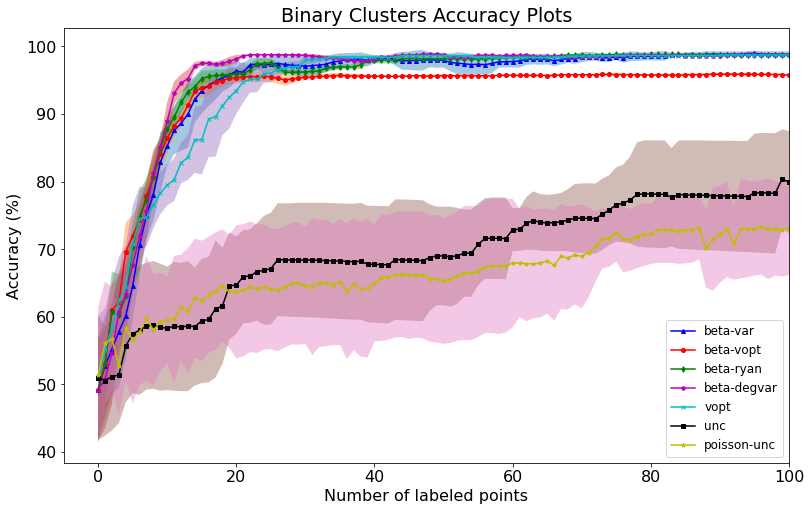

In [38]:
plot_ll = False

plt.figure(figsize= (13,8))
if not plot_ll:
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_var_acc, axis=0), styles[0], label='beta-var')
    plt.fill_between(np.arange(beta_vopt_acc.shape[1]), np.average(beta_var_acc, axis=0)-np.std(beta_var_acc, axis=0), \
                     np.average(beta_var_acc, axis=0)+np.std(beta_var_acc, axis=0), alpha=0.4)
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_vopt_acc, axis=0), styles[1], label='beta-vopt')
    plt.fill_between(np.arange(beta_vopt_acc.shape[1]), np.average(beta_vopt_acc, axis=0)-np.std(beta_vopt_acc, axis=0), \
                     np.average(beta_vopt_acc, axis=0)+np.std(beta_vopt_acc, axis=0), alpha=0.4)
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_ryan_acc, axis=0), styles[2], label='beta-ryan')
    plt.fill_between(np.arange(beta_vopt_acc.shape[1]), np.average(beta_ryan_acc, axis=0)-np.std(beta_ryan_acc, axis=0), \
                     np.average(beta_ryan_acc, axis=0)+np.std(beta_ryan_acc, axis=0), alpha=0.4)
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_deg_var_acc, axis=0), styles[3], label='beta-degvar')
    plt.fill_between(np.arange(beta_vopt_acc.shape[1]), np.average(beta_deg_var_acc, axis=0)-np.std(beta_deg_var_acc, axis=0), \
                     np.average(beta_deg_var_acc, axis=0)+np.std(beta_deg_var_acc, axis=0), alpha=0.4)
else:
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_var_acc_ll, axis=0), styles[0], label='b-var-ll')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_vopt_acc_ll, axis=0), styles[1], label='b-vopt-ll')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_ryan_acc_ll, axis=0), styles[2], label='b-ryan-ll')
    plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(beta_deg_var_acc_ll, axis=0), styles[3], label='b-degvar-ll')
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(vopt_acc, axis=0), styles[4], label='vopt')
plt.fill_between(np.arange(beta_vopt_acc.shape[1]), np.average(vopt_acc, axis=0)-np.std(vopt_acc, axis=0), \
                     np.average(vopt_acc, axis=0)+np.std(vopt_acc, axis=0), alpha=0.4)
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(uncertainty_acc, axis=0), styles[5], label='unc')
plt.fill_between(np.arange(beta_vopt_acc.shape[1]), np.average(uncertainty_acc, axis=0)-np.std(uncertainty_acc, axis=0), \
                     np.average(uncertainty_acc, axis=0)+np.std(uncertainty_acc, axis=0), alpha=0.4)
plt.plot(np.arange(beta_vopt_acc.shape[1]), np.average(poisson_uncertainty_acc, axis=0), styles[6], label='poisson-unc')
plt.fill_between(np.arange(beta_vopt_acc.shape[1]), np.average(poisson_uncertainty_acc, axis=0)-np.std(poisson_uncertainty_acc, axis=0), \
                     np.average(poisson_uncertainty_acc, axis=0)+np.std(poisson_uncertainty_acc, axis=0), alpha=0.4)
# plt.plot([0, 150], [90,90], c='k', linewidth=1.5)
plt.title("Binary Clusters Accuracy Plots")
plt.xlim(-5, 100)
plt.xlabel("Number of labeled points")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

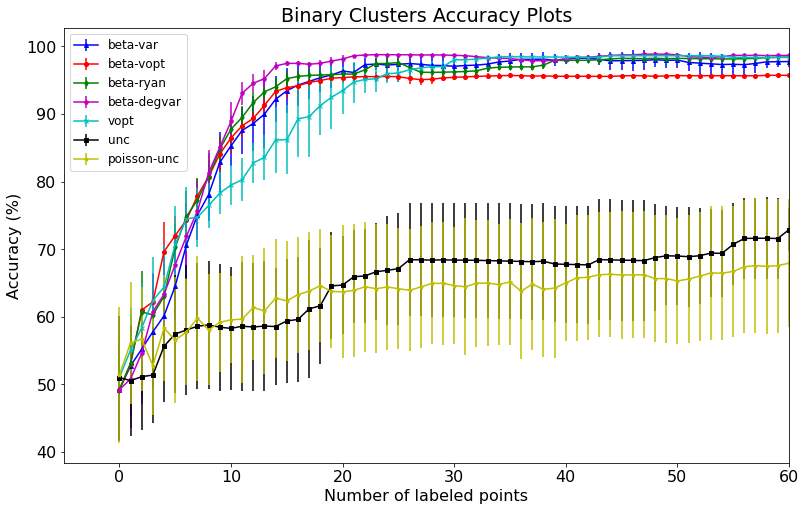

In [24]:
plot_ll = False

plt.figure(figsize= (13,8))
if not plot_ll:
    plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(beta_var_acc, axis=0), np.std(beta_var_acc, axis=0), fmt=styles[0], label='beta-var')
    plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(beta_vopt_acc, axis=0), np.std(beta_vopt_acc, axis=0), fmt=styles[1], label='beta-vopt')
    plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(beta_ryan_acc, axis=0), np.std(beta_ryan_acc, axis=0), fmt=styles[2], label='beta-ryan')
    plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(beta_deg_var_acc, axis=0), np.std(beta_deg_var_acc, axis=0), fmt=styles[3], label='beta-degvar')
else:
    plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(beta_var_acc_ll, axis=0), np.std(beta_var_acc_ll, axis=0), fmt=styles[0], label='b-var-ll')
    plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(beta_vopt_acc_ll, axis=0), np.std(beta_vopt_acc_ll, axis=0), fmt=styles[1], label='b-vopt-ll')
    plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(beta_ryan_acc_ll, axis=0), np.std(beta_ryan_acc_ll, axis=0), fmt=styles[2], label='b-ryan-ll')
    plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(beta_degvar_acc_ll, axis=0), np.std(beta_degvar_acc_ll, axis=0), fmt=styles[3], label='b-degvar-ll')
plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(vopt_acc, axis=0), np.std(vopt_acc, axis=0), fmt=styles[4], label='vopt')
plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(uncertainty_acc, axis=0), np.std(uncertainty_acc, axis=0), fmt=styles[5], label='unc')
plt.errorbar(np.arange(beta_vopt_acc.shape[1]), np.average(poisson_uncertainty_acc, axis=0), np.std(poisson_uncertainty_acc, axis=0), fmt=styles[6], label='poisson-unc')
# plt.plot([0, 150], [90,90], c='k', linewidth=1.5)
plt.title("Binary Clusters Accuracy Plots")
plt.xlim(-5, 60)
plt.xlabel("Number of labeled points")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [19]:
print(np.var(beta_var_acc, axis=0))

[5.79848372e+01 5.59639752e+01 4.53698455e+01 6.80638568e+01
 4.06857503e+01 2.45710386e+01 2.27365324e+01 1.36063589e+01
 1.47776000e+01 1.98972907e+01 9.19743201e+00 1.24363586e+01
 1.61700652e+01 2.47707761e+01 1.15022329e+01 1.11260051e+01
 9.62721863e+00 7.12481401e+00 4.18480643e+00 3.47468784e+00
 2.29801485e+00 1.80441078e+00 9.66593809e-01 8.82780323e-01
 1.26884898e+00 1.04990052e+00 1.90081071e+00 1.45238893e+00
 1.64083318e+00 2.71413007e+00 2.56253019e+00 1.83622848e+00
 1.99591710e+00 1.45902497e+00 1.26369769e+00 1.30947393e+00
 8.71118239e-01 8.92772983e-01 1.01562500e+00 8.48033024e-01
 4.00369333e-01 2.11052950e-01 2.34855342e-01 8.18426329e-01
 1.77639683e+00 1.83724814e+00 2.21641838e+00 2.25193414e+00
 1.22376513e+00 1.26621058e+00 1.19318363e+00 1.75272932e+00
 2.61297338e+00 2.67511695e+00 2.54148373e+00 2.05682211e+00
 2.18525012e+00 2.06837186e+00 7.28367347e-01 7.12442259e-01
 7.60256484e-01 9.85778361e-01 6.99605298e-01 5.96242431e-01
 6.39694707e-01 6.348789

## Observations

* Simply variance maximization (i.e. type of uncertainty sampling for Beta Learning) has great performance, and doesn't seem to be helped (at least in terms of accuracy) by the importance weighting of the Green's functions.
    * However, when you look at the choices that "ryan" vs "var" make, we see that "ryan" chooses closer to cluster centers, while "var" can choose outliers. __Then why do they both give such good performance?__ 
    * I think it has to do with the fact that with clustered data, graph learning does a good job at leveraging how the unlabeled and labeled data interact with eachother. You don't need to get the cluster center labeled in graph learning, because the geometry of the clustered is nicely approximated with graph-based learning. 
* Time step parameter $dt$ is (obviously) very important for the importance weights. Too large of ``dt`` will actually highlight outliers that lie between nicely connected clusters

# Gaussian Cluster 

In [ ]:
matplotlib.pyplot.rcdefaults()

In [ ]:
X, labels, clusters = create_clusters(True)
plt.scatter(X[:,0], X[:,1], c=labels)
plt.show()

W = knn_weight_matrix(15, X)
L = gl.graph_laplacian(W, norm='none')
evals, evecs = eigsh(L, k=200, which='SM')
D = gl.degree_matrix(W).diagonal()

In [ ]:
outlier_inds = []
center_inds = []
bad_inds = []

Sigma =  evecs * np.exp(-0.5*evals)[np.newaxis, :]
weights = Sigma @ evecs.T     
weights[weights < 1e-9] = 0.0
weights /= weights.max(axis=0)[np.newaxis, :]
influence = np.linalg.norm(weights, axis=0)
dist_to_origin = np.linalg.norm(X, axis=1) 
dist_to_origin_middle = np.absolute( dist_to_origin - 2.)

for c in np.unique(clusters):
    cluster_idx = np.where(clusters == c)[0]
    center_inds.append(cluster_idx[np.argmax(influence[cluster_idx])])
    outlier_inds.append(cluster_idx[np.argsort(dist_to_origin[cluster_idx])[-2]])
    middle_band = cluster_idx[dist_to_origin_middle[cluster_idx] < 0.09]
    bad_inds.append(middle_band[np.argmin(influence[middle_band])])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))
ax1.scatter(X[:,0], X[:,1], c=labels)
ax1.scatter(X[outlier_inds,0], X[outlier_inds, 1], c='r', marker='^', s=70)
ax1.set_title("Outlier")
ax2.scatter(X[:,0], X[:,1], c=labels)
ax2.scatter(X[center_inds,0], X[center_inds, 1], c='r', marker='^', s=70)
ax2.set_title("Center")
ax3.scatter(X[:,0], X[:,1], c=labels)
ax3.scatter(X[bad_inds,0], X[bad_inds, 1], c='r', marker='^', s=70)
ax3.set_title("'Bad'")
plt.show()


fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X[:,0], X[:,1], c=labels)
ax.scatter(X[bad_inds,0], X[bad_inds,1], c='r', marker='^', s=70)
plt.show()

In [ ]:
# Center
train_ind = np.array(center_inds) #gl.randomize_labels(labels, 1)
c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
unlabeled_ind = np.delete(np.arange(W.shape[0]), train_ind)


alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .5, thresh=1e-9)
p = (alpha+1.)/(alpha + beta+2.)
p[np.isnan(p)] = 0.5 + 0.0000001*np.random.randn(np.isnan(p).sum())
beta_acc = gl.accuracy(1.*(p >= 0.5), labels, len(train_ind))

u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)

acc_laplace = gl.accuracy(np.argmax(u_laplace,axis=1), labels, len(train_ind))
acc_poisson = gl.accuracy(np.argmax(u_poisson,axis=1), labels, len(train_ind))

gamma = 0.5

C_a = np.linalg.inv(np.diag(evals[1:500]) + evecs[train_ind,1:500].T @ evecs[train_ind,1:500] / gamma**2.) # M by M covariance matrix

vopt_vals = acquisition_function(C_a, evecs[:,1:500], unlabeled_ind, u_laplace, method='vopt', gamma=gamma)


ryan_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='ryan', dt=.5, show=True, thresh=1e-9)

var_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='var', dt=.5, show=False, thresh=1e-9)
degvar_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='deg-var', dt=.5, show=False, thresh=1e-9, deg=D)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c=u_laplace[:,1])
ax1.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=70)
ax1.set_title(f"Laplace Learning, Acc = {acc_laplace:.2f}%")
ax2.scatter(X[:,0], X[:,1], c=p)
ax2.scatter(X[train_ind, 0], X[train_ind, 1], c='r', marker='^', s=80)
ax2.set_title(f"Beta Classifier, Acc = {beta_acc:.2f}%")
plt.show()

In [ ]:
# Outlier
train_ind = np.array(outlier_inds) #gl.randomize_labels(labels, 1)
c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
unlabeled_ind = np.delete(np.arange(W.shape[0]), train_ind)


alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .5, thresh=1e-9)
p = (alpha+1.)/(alpha + beta+2.)
p[np.isnan(p)] = 0.5 + 0.0000001*np.random.randn(np.isnan(p).sum())
beta_acc = gl.accuracy(1.*(p >= 0.5), labels, len(train_ind))

u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)

acc_laplace = gl.accuracy(np.argmax(u_laplace,axis=1), labels, len(train_ind))
acc_poisson = gl.accuracy(np.argmax(u_poisson,axis=1), labels, len(train_ind))

gamma = 0.5

C_a = np.linalg.inv(np.diag(evals[1:500]) + evecs[train_ind,1:500].T @ evecs[train_ind,1:500] / gamma**2.) # M by M covariance matrix

vopt_vals = acquisition_function(C_a, evecs[:,1:500], unlabeled_ind, u_laplace, method='vopt', gamma=gamma)


ryan_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='ryan', dt=.5, show=True, thresh=1e-9)

var_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='var', dt=.5, show=False, thresh=1e-9)
degvar_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='deg-var', dt=.5, show=False, thresh=1e-9, deg=D)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c=u_laplace[:,1])
ax1.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=70)
ax1.set_title(f"Laplace Learning, Acc = {acc_laplace:.2f}%")
ax2.scatter(X[:,0], X[:,1], c=p)
ax2.scatter(X[train_ind, 0], X[train_ind, 1], c='r', marker='^', s=80)
ax2.set_title(f"Beta Classifier, Acc = {beta_acc:.2f}%")
plt.show()

In [ ]:
# Bad
train_ind = np.array(bad_inds) #gl.randomize_labels(labels, 1)
c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
unlabeled_ind = np.delete(np.arange(W.shape[0]), train_ind)


alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .5, thresh=1e-9)
p = (alpha+1.)/(alpha + beta+2.)
p[np.isnan(p)] = 0.5 + 0.0000001*np.random.randn(np.isnan(p).sum())
beta_acc = gl.accuracy(1.*(p >= 0.5), labels, len(train_ind))

u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)

acc_laplace = gl.accuracy(np.argmax(u_laplace,axis=1), labels, len(train_ind))
acc_poisson = gl.accuracy(np.argmax(u_poisson,axis=1), labels, len(train_ind))

gamma = 0.5

C_a = np.linalg.inv(np.diag(evals[1:500]) + evecs[train_ind,1:500].T @ evecs[train_ind,1:500] / gamma**2.) # M by M covariance matrix

vopt_vals = acquisition_function(C_a, evecs[:,1:500], unlabeled_ind, u_laplace, method='vopt', gamma=gamma)


ryan_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='ryan', dt=.5, show=True, thresh=1e-9)

var_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='var', dt=.5, show=False, thresh=1e-9)
degvar_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='deg-var', dt=.5, show=False, thresh=1e-9, deg=D)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c=u_laplace[:,1])
ax1.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=70)
ax1.set_title(f"Laplace Learning, Acc = {acc_laplace:.2f}%")
ax2.scatter(X[:,0], X[:,1], c=p)
ax2.scatter(X[train_ind, 0], X[train_ind, 1], c='r', marker='^', s=80)
ax2.set_title(f"Beta Classifier, Acc = {beta_acc:.2f}%")
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=ryan_vals)
ax1.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=70)
ax1.set_title("Ryan")
ax2.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=var_vals)
ax2.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=70)
ax2.set_title("Variance")
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=degvar_vals)
ax1.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=70)
ax1.set_title("Deg-Var")
ax2.scatter(X[unlabeled_ind,0], X[unlabeled_ind,1], c=vopt_vals)
ax2.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=70)
ax2.set_title("VOpt")
plt.show()

# Observation

Indeed, you can choose "outliers" and the accuracy can be just as good (if not better!) than if I had chosen cluster centers! __Does this generalize to higher dimensions, though?__

In [ ]:
def create_clusters_hd(return_clusters=False):
    N, nc = 800, 8
    np.random.seed(5)
    centers = 2.*np.hstack((np.cos(2.*np.pi*np.arange(nc)/float(nc))[:,np.newaxis],
        np.sin(2.*np.pi*np.arange(nc)/float(nc))[:,np.newaxis]))
    centers =  centers @ np.random.randn(2, 20)
    X, clusters = make_blobs(N, 2, shuffle=False, centers=centers, cluster_std=.32)  # DECREASE std for better clustering
    # Divide into classes by alternating clusters
    labels = np.copy(clusters)
    labels[clusters % 2 == 0] = 0
    labels[clusters % 2 == 1] = 1
    if return_clusters:
        origin = np.mean(centers, axis=0)
        return X, labels, clusters, origin
    return X, labels

In [ ]:
X_, labels, clusters, origin = create_clusters_hd(True)
X = X_[:,:2]
plt.scatter(X[:,0], X[:,1], c=labels)
plt.show()

W = knn_weight_matrix(15, X)
L = gl.graph_laplacian(W, norm='none')
evals, evecs = eigsh(L, k=200, which='SM')
D = gl.degree_matrix(W).diagonal()

In [ ]:
outlier_inds = []
center_inds = []
Sigma =  evecs * np.exp(-0.5*evals)[np.newaxis, :]
weights = Sigma @ evecs.T     
weights[weights < 1e-9] = 0.0
weights /= weights.max(axis=0)[np.newaxis, :]
influence = np.linalg.norm(weights, axis=0)
dist_to_mean = np.linalg.norm(X_ - origin, axis=1)


for c in np.unique(clusters):
    cluster_idx = np.where(clusters == c)[0]
    center_inds.append(cluster_idx[np.argmax(influence[cluster_idx])])
    outlier_inds.append(cluster_idx[np.argsort(dist_to_origin[cluster_idx])[-2]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c=labels)
ax1.scatter(X[outlier_inds,0], X[outlier_inds, 1], c='r', marker='^', s=70)
ax1.scatter(origin[0], origin[1], c='pink', s=100)
ax1.set_title("Outlier")
ax2.scatter(X[:,0], X[:,1], c=labels)
ax2.scatter(X[center_inds,0], X[center_inds, 1], c='r', marker='^', s=70)
ax2.scatter(origin[0], origin[1], c='pink', s=100)
ax2.set_title("Center")
plt.show()

In [ ]:
# Center
train_ind = np.array(center_inds) #gl.randomize_labels(labels, 1)
c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
unlabeled_ind = np.delete(np.arange(W.shape[0]), train_ind)


alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .5, thresh=1e-9)
p = (alpha+1.)/(alpha + beta+2.)
p[np.isnan(p)] = 0.5 + 0.0000001*np.random.randn(np.isnan(p).sum())
beta_acc = gl.accuracy(1.*(p >= 0.5), labels, len(train_ind))

u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)

acc_laplace = gl.accuracy(np.argmax(u_laplace,axis=1), labels, len(train_ind))
acc_poisson = gl.accuracy(np.argmax(u_poisson,axis=1), labels, len(train_ind))

gamma = 0.5

C_a = np.linalg.inv(np.diag(evals[1:500]) + evecs[train_ind,1:500].T @ evecs[train_ind,1:500] / gamma**2.) # M by M covariance matrix

vopt_vals = acquisition_function(C_a, evecs[:,1:500], unlabeled_ind, u_laplace, method='vopt', gamma=gamma)


ryan_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='ryan', dt=.5, show=True, thresh=1e-9)

var_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='var', dt=.5, show=False, thresh=1e-9)
degvar_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='deg-var', dt=.5, show=False, thresh=1e-9, deg=D)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c=u_laplace[:,1])
ax1.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=70)
ax1.set_title(f"Laplace Learning, Acc = {acc_laplace}")
ax2.scatter(X[:,0], X[:,1], c=p)
ax2.scatter(X[train_ind, 0], X[train_ind, 1], c='r', marker='^', s=80)
ax2.set_title(f"Beta Classifier, Acc = {beta_acc}")
plt.show()

In [ ]:
# Outlier
train_ind = np.array(outlier_inds) #gl.randomize_labels(labels, 1)
c0_ind, c1_ind = train_ind[labels[train_ind] == 0], train_ind[labels[train_ind] == 1]
unlabeled_ind = np.delete(np.arange(W.shape[0]), train_ind)


alpha, beta = prop_alpha_beta_thresh(evecs, evals, c0_ind, c1_ind, .5, thresh=1e-9)
p = (alpha+1.)/(alpha + beta+2.)
p[np.isnan(p)] = 0.5 + 0.0000001*np.random.randn(np.isnan(p).sum())
beta_acc = gl.accuracy(1.*(p >= 0.5), labels, len(train_ind))

u_laplace = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='laplace', return_vector=True)
u_poisson = gl.graph_ssl(W, train_ind, labels[train_ind], algorithm='poisson', return_vector=True)

acc_laplace = gl.accuracy(np.argmax(u_laplace,axis=1), labels, len(train_ind))
acc_poisson = gl.accuracy(np.argmax(u_poisson,axis=1), labels, len(train_ind))

gamma = 0.5

C_a = np.linalg.inv(np.diag(evals[1:500]) + evecs[train_ind,1:500].T @ evecs[train_ind,1:500] / gamma**2.) # M by M covariance matrix

vopt_vals = acquisition_function(C_a, evecs[:,1:500], unlabeled_ind, u_laplace, method='vopt', gamma=gamma)


ryan_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='ryan', dt=.5, show=True, thresh=1e-9)

var_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='var', dt=.5, show=False, thresh=1e-9)
degvar_vals = beta_look_ahead_acquisition(alpha, beta, evecs, evals, unlabeled_ind, classifier='mean', \
                                        method='deg-var', dt=.5, show=False, thresh=1e-9, deg=D)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.scatter(X[:,0], X[:,1], c=u_laplace[:,1])
ax1.scatter(X[train_ind,0], X[train_ind,1], c='r', marker='^', s=70)
ax1.set_title(f"Laplace Learning, Acc = {acc_laplace}")
ax2.scatter(X[:,0], X[:,1], c=p)
ax2.scatter(X[train_ind, 0], X[train_ind, 1], c='r', marker='^', s=80)
ax2.set_title(f"Beta Classifier, Acc = {beta_acc}")
plt.show()

## Interpretations

Maybe this is saying that with graph-based learning, you don't necessarily need the cluster center, as long as you make sure you have some point in the cluster that doesn't lie too close to other clusters? Diffusion geometry spreads easily through clusters, and then slows when going across cluster boundaries. If I choose a point that "away from" other clusters, but still "a part" of the given cluster, then I can spread enough mass/to my cluster, but not to other clusters that might misclassify... 
* I think that this might say that you could choose cluster medians, even without trying to choose the cluster centers! Dirichlet evecs straightforwardly work okay?


But how does the AL process change from these different starting points? Does choosing cluster centers help the accuracy here as we refine?